# Import Packages

In [ ]:
import torch
torch.__version__

assert torch.cuda.is_available()

# See https://detectron2.readthedocs.io/tutorials/install.html for instructions

# %%capture
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install tensorflow_addons
!pip install transformers


import torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy
import gc
import os
from getpass import getpass
import urllib
import pandas as pd


import tensorflow_addons as tfa
import tensorflow as tf


from transformers import BertTokenizer, VisualBertModel, VisualBertForPreTraining, VisualBertForQuestionAnswering, AutoTokenizer


from keras.models import Sequential
from keras import layers
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
# from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

plt.rcParams['figure.dpi'] = 150

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-d4m13zdw
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-d4m13zdw
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load in Data

In [ ]:
from google.colab import drive
import re
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_feather("/content/drive/MyDrive/multimodal/DL_data.feather")

In [ ]:
data

,status_id,V101_02,V301_02,screen_name,text,media_url,lang
0,1194204999078875137,https://twitter.com/EU_Finance/status/11942049...,0.0,EU_Finance,The exchange of ideas continues at today's #EU...,http://pbs.twimg.com/media/EJKrHGBWoAA1yd0.jpg,en
1,1202605773957844992,https://twitter.com/EU_Competition/status/1202...,0.0,EU_Competition,Executive Vice President of the European Commi...,http://pbs.twimg.com/media/ELCDk2LW4AA9ALd.jpg,en
2,1222801468807360513,https://twitter.com/BaldwinMatthew_/status/122...,1.0,BaldwinMatthew_,Pls read/retweet this important report from @E...,http://pbs.twimg.com/media/EPhDdAvWoAEVdLv.jpg,en
3,1280416638802767872,https://twitter.com/EU_Commission/status/12804...,0.0,EU_Commission,The #coronavirus has claimed more than half a ...,http://pbs.twimg.com/media/EcTzgpVXgAAuXAz.jpg,en
4,1227338517287751685,https://twitter.com/dreynders/status/122733851...,0.0,dreynders,Today I made a statement in @Europarl_EN on th...,http://pbs.twimg.com/media/EQhh3aGW4AAynsi.jpg,en
...,...,...,...,...,...,...,...
895,1275414642731429889,https://twitter.com/ESMAComms/status/127541464...,1.0,ESMAComms,.@VDombrovskis: When we come w/ our proposal o...,http://pbs.twimg.com/media/EbMqx7BXkAEt2D-.jpg,en
896,1222647612970610688,https://twitter.com/SandraGallina/status/12226...,0.0,SandraGallina,#Brexit,http://pbs.twimg.com/amplify_video_thumb/12225...,en
897,1214881110963998720,https://twitter.com/vonderleyen/status/1214881...,1.0,vonderleyen,But we are ready to design a new partnership w...,http://pbs.twimg.com/media/ENwf7iGWkAARWa1.jpg,en
898,1202967402838974464,https://twitter.com/DSMeu/status/1202967402838...,0.0,DSMeu,Hyvää itsenäisyyspäivää Suomi! #Finland is bes...,http://pbs.twimg.com/media/D8ywUFnXUAA-1PI.jpg,en


In [ ]:
data["status_id"] = pd.to_numeric(data["status_id"])
data["V301_02"] = pd.to_numeric(data["V301_02"])
data = data.sort_values(by=['status_id'])

In [ ]:
data=data[data["status_id"] != 1202992784652808192] 
data=data[data["status_id"] != 1235481777197604865] 

In [ ]:
data

,status_id,V101_02,V301_02,screen_name,text,media_url,lang
347,1183662782589427712,https://twitter.com/DSMeu/status/1183662782589...,1.0,DSMeu,And the winner of the European Cyber Security ...,http://pbs.twimg.com/ext_tw_video_thumb/118366...,en
764,1183741219274481667,https://twitter.com/Trade_EU/status/1183741219...,1.0,Trade_EU,Our latest Free Trade Agreement implementation...,http://pbs.twimg.com/amplify_video_thumb/11837...,en
296,1183787259134386176,https://twitter.com/MarosSefcovic/status/11837...,0.0,MarosSefcovic,Let's start looking at what should be our prio...,http://pbs.twimg.com/media/EG2oO_2XUAALu2r.jpg,en
172,1183993915675824128,https://twitter.com/EU_Commission/status/11839...,0.0,EU_Commission,What matters most to you? What 𝙧𝙚𝙖𝙡𝙡𝙮 matters ...,http://pbs.twimg.com/media/EG5kMHYUUAEpIMT.jpg,en
472,1184036846923407360,https://twitter.com/eu_echo/status/11840368469...,1.0,eu_echo,“I come from an area with lots of electricity ...,http://pbs.twimg.com/media/EG6LO_1WoAIo7if.jpg,en
...,...,...,...,...,...,...,...
263,1288782299090358277,https://twitter.com/EU_Competition/status/1288...,1.0,EU_Competition,#EUStateAid #coronavirus #StrongerTogether Com...,http://pbs.twimg.com/media/EeKsnlMXsAA8gH-.jpg,en
704,1288782490644160517,https://twitter.com/GabrielMariya/status/12887...,0.0,GabrielMariya,"Friendship is a priceless gift, a feeling, abl...",http://pbs.twimg.com/media/EeKs18PX0AA-v_b.jpg,en
164,1288793253286993920,https://twitter.com/VSinkevicius/status/128879...,0.0,VSinkevicius,Dreaming of a cleaner Baltic Sea? 🌊🌊🌊 So do we...,http://pbs.twimg.com/media/EeK2oMxWsAEX4t8.jpg,en
48,1288807236769382400,https://twitter.com/EURightsAgency/status/1288...,1.0,EURightsAgency,Want to know how controlling #COVID19 has affe...,http://pbs.twimg.com/media/EeKpQGgXkAIy1Mv.jpg,en


In [ ]:
labels = data["V301_02"].to_numpy()
labels = torch.Tensor(labels).int()

In [ ]:
tweets = data["text"].to_list()

In [ ]:
sum(labels.numpy())

479

In [ ]:
len(tweets)

898

# Define functions

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.

# they removed this part from the detectron2 codebase (we need the FastRCNNOutputs class)
# however thanks to github nothing is ever gone
# from here: https://github.com/facebookresearch/detectron2/commit/11528ce#
import logging
from typing import Dict, List, Tuple, Union
import torch
from fvcore.nn import giou_loss, smooth_l1_loss
from torch import nn
from torch.nn import functional as F
from detectron2.config import configurable
from detectron2.layers import ShapeSpec, batched_nms, cat, cross_entropy, nonzero_tuple
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.structures import Boxes, Instances
from detectron2.utils.events import get_event_storage
__all__ = ["fast_rcnn_inference", "FastRCNNOutputLayers"]
logger = logging.getLogger(__name__)
"""
Shape shorthand in this module:
    N: number of images in the minibatch
    R: number of ROIs, combined over all images, in the minibatch
    Ri: number of ROIs in image i
    K: number of foreground classes. E.g.,there are 80 foreground classes in COCO.
Naming convention:
    deltas: refers to the 4-d (dx, dy, dw, dh) deltas that parameterize the box2box
    transform (see :class:`box_regression.Box2BoxTransform`).
    pred_class_logits: predicted class scores in [-inf, +inf]; use
        softmax(pred_class_logits) to estimate P(class).
    gt_classes: ground-truth classification labels in [0, K], where [0, K) represent
        foreground object classes and K represents the background class.
    pred_proposal_deltas: predicted box2box transform deltas for transforming proposals
        to detection box predictions.
    gt_proposal_deltas: ground-truth box2box transform deltas
"""
def fast_rcnn_inference(
    boxes: List[torch.Tensor],
    scores: List[torch.Tensor],
    image_shapes: List[Tuple[int, int]],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    """
    Call `fast_rcnn_inference_single_image` for all images.
    Args:
        boxes (list[Tensor]): A list of Tensors of predicted class-specific or class-agnostic
            boxes for each image. Element i has shape (Ri, K * 4) if doing
            class-specific regression, or (Ri, 4) if doing class-agnostic
            regression, where Ri is the number of predicted objects for image i.
            This is compatible with the output of :meth:`FastRCNNOutputLayers.predict_boxes`.
        scores (list[Tensor]): A list of Tensors of predicted class scores for each image.
            Element i has shape (Ri, K + 1), where Ri is the number of predicted objects
            for image i. Compatible with the output of :meth:`FastRCNNOutputLayers.predict_probs`.
        image_shapes (list[tuple]): A list of (width, height) tuples for each image in the batch.
        score_thresh (float): Only return detections with a confidence score exceeding this
            threshold.
        nms_thresh (float):  The threshold to use for box non-maximum suppression. Value in [0, 1].
        topk_per_image (int): The number of top scoring detections to return. Set < 0 to return
            all detections.
    Returns:
        instances: (list[Instances]): A list of N instances, one for each image in the batch,
            that stores the topk most confidence detections.
        kept_indices: (list[Tensor]): A list of 1D tensor of length of N, each element indicates
            the corresponding boxes/scores index in [0, Ri) from the input, for image i.
    """
    result_per_image = [
        fast_rcnn_inference_single_image(
            boxes_per_image, scores_per_image, image_shape, score_thresh, nms_thresh, topk_per_image
        )
        for scores_per_image, boxes_per_image, image_shape in zip(scores, boxes, image_shapes)
    ]
    return [x[0] for x in result_per_image], [x[1] for x in result_per_image]
def _log_classification_stats(pred_logits, gt_classes, prefix="fast_rcnn"):
    """
    Log the classification metrics to EventStorage.
    Args:
        pred_logits: Rx(K+1) logits. The last column is for background class.
        gt_classes: R labels
    """
    num_instances = gt_classes.numel()
    if num_instances == 0:
        return
    pred_classes = pred_logits.argmax(dim=1)
    bg_class_ind = pred_logits.shape[1] - 1
    fg_inds = (gt_classes >= 0) & (gt_classes < bg_class_ind)
    num_fg = fg_inds.nonzero().numel()
    fg_gt_classes = gt_classes[fg_inds]
    fg_pred_classes = pred_classes[fg_inds]
    num_false_negative = (fg_pred_classes == bg_class_ind).nonzero().numel()
    num_accurate = (pred_classes == gt_classes).nonzero().numel()
    fg_num_accurate = (fg_pred_classes == fg_gt_classes).nonzero().numel()
    storage = get_event_storage()
    storage.put_scalar(f"{prefix}/cls_accuracy", num_accurate / num_instances)
    if num_fg > 0:
        storage.put_scalar(f"{prefix}/fg_cls_accuracy", fg_num_accurate / num_fg)
        storage.put_scalar(f"{prefix}/false_negative", num_false_negative / num_fg)
def fast_rcnn_inference_single_image(
    boxes,
    scores,
    image_shape: Tuple[int, int],
    score_thresh: float,
    nms_thresh: float,
    topk_per_image: int,
):
    """
    Single-image inference. Return bounding-box detection results by thresholding
    on scores and applying non-maximum suppression (NMS).
    Args:
        Same as `fast_rcnn_inference`, but with boxes, scores, and image shapes
        per image.
    Returns:
        Same as `fast_rcnn_inference`, but for only one image.
    """
    valid_mask = torch.isfinite(boxes).all(dim=1) & torch.isfinite(scores).all(dim=1)
    if not valid_mask.all():
        boxes = boxes[valid_mask]
        scores = scores[valid_mask]
    scores = scores[:, :-1]
    num_bbox_reg_classes = boxes.shape[1] // 4
    # Convert to Boxes to use the `clip` function ...
    boxes = Boxes(boxes.reshape(-1, 4))
    boxes.clip(image_shape)
    boxes = boxes.tensor.view(-1, num_bbox_reg_classes, 4)  # R x C x 4
    # 1. Filter results based on detection scores. It can make NMS more efficient
    #    by filtering out low-confidence detections.
    filter_mask = scores > score_thresh  # R x K
    # R' x 2. First column contains indices of the R predictions;
    # Second column contains indices of classes.
    filter_inds = filter_mask.nonzero()
    if num_bbox_reg_classes == 1:
        boxes = boxes[filter_inds[:, 0], 0]
    else:
        boxes = boxes[filter_mask]
    scores = scores[filter_mask]
    # 2. Apply NMS for each class independently.
    keep = batched_nms(boxes, scores, filter_inds[:, 1], nms_thresh)
    if topk_per_image >= 0:
        keep = keep[:topk_per_image]
    boxes, scores, filter_inds = boxes[keep], scores[keep], filter_inds[keep]
    result = Instances(image_shape)
    result.pred_boxes = Boxes(boxes)
    result.scores = scores
    result.pred_classes = filter_inds[:, 1]
    return result, filter_inds[:, 0]


class FastRCNNOutputs:
    """
    An internal implementation that stores information about outputs of a Fast R-CNN head,
    and provides methods that are used to decode the outputs of a Fast R-CNN head.
    """

    def __init__(
        self,
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta=0.0,
        box_reg_loss_type="smooth_l1",
    ):
        """
        Args:
            box2box_transform (Box2BoxTransform/Box2BoxTransformRotated):
                box2box transform instance for proposal-to-detection transformations.
            pred_class_logits (Tensor): A tensor of shape (R, K + 1) storing the predicted class
                logits for all R predicted object instances.
                Each row corresponds to a predicted object instance.
            pred_proposal_deltas (Tensor): A tensor of shape (R, K * B) or (R, B) for
                class-specific or class-agnostic regression. It stores the predicted deltas that
                transform proposals into final box detections.
                B is the box dimension (4 or 5).
                When B is 4, each row is [dx, dy, dw, dh (, ....)].
                When B is 5, each row is [dx, dy, dw, dh, da (, ....)].
            proposals (list[Instances]): A list of N Instances, where Instances i stores the
                proposals for image i, in the field "proposal_boxes".
                When training, each Instances must have ground-truth labels
                stored in the field "gt_classes" and "gt_boxes".
                The total number of all instances must be equal to R.
            smooth_l1_beta (float): The transition point between L1 and L2 loss in
                the smooth L1 loss function. When set to 0, the loss becomes L1. When
                set to +inf, the loss becomes constant 0.
            box_reg_loss_type (str): Box regression loss type. One of: "smooth_l1", "giou"
        """
        self.box2box_transform = box2box_transform
        self.num_preds_per_image = [len(p) for p in proposals]
        self.pred_class_logits = pred_class_logits
        self.pred_proposal_deltas = pred_proposal_deltas
        self.smooth_l1_beta = smooth_l1_beta
        self.box_reg_loss_type = box_reg_loss_type

        self.image_shapes = [x.image_size for x in proposals]

        if len(proposals):
            box_type = type(proposals[0].proposal_boxes)
            # cat(..., dim=0) concatenates over all images in the batch
            self.proposals = box_type.cat([p.proposal_boxes for p in proposals])
            assert (
                not self.proposals.tensor.requires_grad
            ), "Proposals should not require gradients!"

            # "gt_classes" exists if and only if training. But other gt fields may
            # not necessarily exist in training for images that have no groundtruth.
            if proposals[0].has("gt_classes"):
                self.gt_classes = cat([p.gt_classes for p in proposals], dim=0)

                # If "gt_boxes" does not exist, the proposals must be all negative and
                # should not be included in regression loss computation.
                # Here we just use proposal_boxes as an arbitrary placeholder because its
                # value won't be used in self.box_reg_loss().
                gt_boxes = [
                    p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes for p in proposals
                ]
                self.gt_boxes = box_type.cat(gt_boxes)
        else:
            self.proposals = Boxes(torch.zeros(0, 4, device=self.pred_proposal_deltas.device))
        self._no_instances = len(self.proposals) == 0  # no instances found

    def softmax_cross_entropy_loss(self):
        """
        Deprecated
        """
        _log_classification_stats(self.pred_class_logits, self.gt_classes)
        return cross_entropy(self.pred_class_logits, self.gt_classes, reduction="mean")

    def box_reg_loss(self):
        """
        Deprecated
        """
        if self._no_instances:
            return 0.0 * self.pred_proposal_deltas.sum()

        box_dim = self.proposals.tensor.size(1)  # 4 or 5
        cls_agnostic_bbox_reg = self.pred_proposal_deltas.size(1) == box_dim
        device = self.pred_proposal_deltas.device

        bg_class_ind = self.pred_class_logits.shape[1] - 1
        # Box delta loss is only computed between the prediction for the gt class k
        # (if 0 <= k < bg_class_ind) and the target; there is no loss defined on predictions
        # for non-gt classes and background.
        # Empty fg_inds should produce a valid loss of zero because reduction=sum.
        fg_inds = nonzero_tuple((self.gt_classes >= 0) & (self.gt_classes < bg_class_ind))[0]

        if cls_agnostic_bbox_reg:
            # pred_proposal_deltas only corresponds to foreground class for agnostic
            gt_class_cols = torch.arange(box_dim, device=device)
        else:
            # pred_proposal_deltas for class k are located in columns [b * k : b * k + b],
            # where b is the dimension of box representation (4 or 5)
            # Note that compared to Detectron1,
            # we do not perform bounding box regression for background classes.
            gt_class_cols = box_dim * self.gt_classes[fg_inds, None] + torch.arange(
                box_dim, device=device
            )

        if self.box_reg_loss_type == "smooth_l1":
            gt_proposal_deltas = self.box2box_transform.get_deltas(
                self.proposals.tensor, self.gt_boxes.tensor
            )
            loss_box_reg = smooth_l1_loss(
                self.pred_proposal_deltas[fg_inds[:, None], gt_class_cols],
                gt_proposal_deltas[fg_inds],
                self.smooth_l1_beta,
                reduction="sum",
            )
        elif self.box_reg_loss_type == "giou":
            fg_pred_boxes = self.box2box_transform.apply_deltas(
                self.pred_proposal_deltas[fg_inds[:, None], gt_class_cols],
                self.proposals.tensor[fg_inds],
            )
            loss_box_reg = giou_loss(
                fg_pred_boxes,
                self.gt_boxes.tensor[fg_inds],
                reduction="sum",
            )
        else:
            raise ValueError(f"Invalid bbox reg loss type '{self.box_reg_loss_type}'")

        loss_box_reg = loss_box_reg / self.gt_classes.numel()
        return loss_box_reg

    def losses(self):
        """
        Deprecated
        """
        return {"loss_cls": self.softmax_cross_entropy_loss(), "loss_box_reg": self.box_reg_loss()}

    def predict_boxes(self):
        """
        Deprecated
        """
        pred = self.box2box_transform.apply_deltas(self.pred_proposal_deltas, self.proposals.tensor)
        return pred.split(self.num_preds_per_image, dim=0)

    def predict_probs(self):
        """
        Deprecated
        """
        probs = F.softmax(self.pred_class_logits, dim=-1)
        return probs.split(self.num_preds_per_image, dim=0)


class FastRCNNOutputLayers(nn.Module):
    """
    Two linear layers for predicting Fast R-CNN outputs:
    1. proposal-to-detection box regression deltas
    2. classification scores
    """
    @configurable
    def __init__(
        self,
        input_shape: ShapeSpec,
        *,
        box2box_transform,
        num_classes: int,
        test_score_thresh: float = 0.0,
        test_nms_thresh: float = 0.5,
        test_topk_per_image: int = 100,
        cls_agnostic_bbox_reg: bool = False,
        smooth_l1_beta: float = 0.0,
        box_reg_loss_type: str = "smooth_l1",
        loss_weight: Union[float, Dict[str, float]] = 1.0,
    ):
        """
        NOTE: this interface is experimental.
        Args:
            input_shape (ShapeSpec): shape of the input feature to this module
            box2box_transform (Box2BoxTransform or Box2BoxTransformRotated):
            num_classes (int): number of foreground classes
            test_score_thresh (float): threshold to filter predictions results.
            test_nms_thresh (float): NMS threshold for prediction results.
            test_topk_per_image (int): number of top predictions to produce per image.
            cls_agnostic_bbox_reg (bool): whether to use class agnostic for bbox regression
            smooth_l1_beta (float): transition point from L1 to L2 loss. Only used if
                `box_reg_loss_type` is "smooth_l1"
            box_reg_loss_type (str): Box regression loss type. One of: "smooth_l1", "giou"
            loss_weight (float|dict): weights to use for losses. Can be single float for weighting
                all losses, or a dict of individual weightings. Valid dict keys are:
                    * "loss_cls": applied to classification loss
                    * "loss_box_reg": applied to box regression loss
        """
        super().__init__()
        if isinstance(input_shape, int):  # some backward compatibility
            input_shape = ShapeSpec(channels=input_shape)
        self.num_classes = num_classes
        input_size = input_shape.channels * (input_shape.width or 1) * (input_shape.height or 1)
        # prediction layer for num_classes foreground classes and one background class (hence + 1)
        self.cls_score = nn.Linear(input_size, num_classes + 1)
        num_bbox_reg_classes = 1 if cls_agnostic_bbox_reg else num_classes
        box_dim = len(box2box_transform.weights)
        self.bbox_pred = nn.Linear(input_size, num_bbox_reg_classes * box_dim)
        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.normal_(self.bbox_pred.weight, std=0.001)
        for l in [self.cls_score, self.bbox_pred]:
            nn.init.constant_(l.bias, 0)
        self.box2box_transform = box2box_transform
        self.smooth_l1_beta = smooth_l1_beta
        self.test_score_thresh = test_score_thresh
        self.test_nms_thresh = test_nms_thresh
        self.test_topk_per_image = test_topk_per_image
        self.box_reg_loss_type = box_reg_loss_type
        if isinstance(loss_weight, float):
            loss_weight = {"loss_cls": loss_weight, "loss_box_reg": loss_weight}
        self.loss_weight = loss_weight
    @classmethod
    def from_config(cls, cfg, input_shape):
        return {
            "input_shape": input_shape,
            "box2box_transform": Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS),
            # fmt: off
            "num_classes"           : cfg.MODEL.ROI_HEADS.NUM_CLASSES,
            "cls_agnostic_bbox_reg" : cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG,
            "smooth_l1_beta"        : cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA,
            "test_score_thresh"     : cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST,
            "test_nms_thresh"       : cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST,
            "test_topk_per_image"   : cfg.TEST.DETECTIONS_PER_IMAGE,
            "box_reg_loss_type"     : cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE,
            "loss_weight"           : {"loss_box_reg": cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT},
            # fmt: on
        }
    def forward(self, x):
        """
        Args:
            x: per-region features of shape (N, ...) for N bounding boxes to predict.
        Returns:
            (Tensor, Tensor):
            First tensor: shape (N,K+1), scores for each of the N box. Each row contains the
            scores for K object categories and 1 background class.
            Second tensor: bounding box regression deltas for each box. Shape is shape (N,Kx4),
            or (N,4) for class-agnostic regression.
        """
        if x.dim() > 2:
            x = torch.flatten(x, start_dim=1)
        scores = self.cls_score(x)
        proposal_deltas = self.bbox_pred(x)
        return scores, proposal_deltas
    def losses(self, predictions, proposals):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were used
                to compute predictions. The fields ``proposal_boxes``, ``gt_boxes``,
                ``gt_classes`` are expected.
        Returns:
            Dict[str, Tensor]: dict of losses
        """
        scores, proposal_deltas = predictions
        # parse classification outputs
        gt_classes = (
            cat([p.gt_classes for p in proposals], dim=0) if len(proposals) else torch.empty(0)
        )
        _log_classification_stats(scores, gt_classes)
        # parse box regression outputs
        if len(proposals):
            proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)  # Nx4
            assert not proposal_boxes.requires_grad, "Proposals should not require gradients!"
            # If "gt_boxes" does not exist, the proposals must be all negative and
            # should not be included in regression loss computation.
            # Here we just use proposal_boxes as an arbitrary placeholder because its
            # value won't be used in self.box_reg_loss().
            gt_boxes = cat(
                [(p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes).tensor for p in proposals],
                dim=0,
            )
        else:
            proposal_boxes = gt_boxes = torch.empty((0, 4), device=proposal_deltas.device)
        losses = {
            "loss_cls": cross_entropy(scores, gt_classes, reduction="mean"),
            "loss_box_reg": self.box_reg_loss(
                proposal_boxes, gt_boxes, proposal_deltas, gt_classes
            ),
        }
        return {k: v * self.loss_weight.get(k, 1.0) for k, v in losses.items()}
    def box_reg_loss(self, proposal_boxes, gt_boxes, pred_deltas, gt_classes):
        """
        Args:
            All boxes are tensors with the same shape Rx(4 or 5).
            gt_classes is a long tensor of shape R, the gt class label of each proposal.
            R shall be the number of proposals.
        """
        box_dim = proposal_boxes.shape[1]  # 4 or 5
        # Regression loss is only computed for foreground proposals (those matched to a GT)
        fg_inds = nonzero_tuple((gt_classes >= 0) & (gt_classes < self.num_classes))[0]
        if pred_deltas.shape[1] == box_dim:  # cls-agnostic regression
            fg_pred_deltas = pred_deltas[fg_inds]
        else:
            fg_pred_deltas = pred_deltas.view(-1, self.num_classes, box_dim)[
                fg_inds, gt_classes[fg_inds]
            ]
        if self.box_reg_loss_type == "smooth_l1":
            gt_pred_deltas = self.box2box_transform.get_deltas(
                proposal_boxes[fg_inds],
                gt_boxes[fg_inds],
            )
            loss_box_reg = smooth_l1_loss(
                fg_pred_deltas, gt_pred_deltas, self.smooth_l1_beta, reduction="sum"
            )
        elif self.box_reg_loss_type == "giou":
            fg_pred_boxes = self.box2box_transform.apply_deltas(
                fg_pred_deltas, proposal_boxes[fg_inds]
            )
            loss_box_reg = giou_loss(fg_pred_boxes, gt_boxes[fg_inds], reduction="sum")
        else:
            raise ValueError(f"Invalid bbox reg loss type '{self.box_reg_loss_type}'")
        # The reg loss is normalized using the total number of regions (R), not the number
        # of foreground regions even though the box regression loss is only defined on
        # foreground regions. Why? Because doing so gives equal training influence to
        # each foreground example. To see how, consider two different minibatches:
        #  (1) Contains a single foreground region
        #  (2) Contains 100 foreground regions
        # If we normalize by the number of foreground regions, the single example in
        # minibatch (1) will be given 100 times as much influence as each foreground
        # example in minibatch (2). Normalizing by the total number of regions, R,
        # means that the single example in minibatch (1) and each of the 100 examples
        # in minibatch (2) are given equal influence.
        return loss_box_reg / max(gt_classes.numel(), 1.0)  # return 0 if empty
    def inference(self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions. The ``proposal_boxes`` field is expected.
        Returns:
            list[Instances]: same as `fast_rcnn_inference`.
            list[Tensor]: same as `fast_rcnn_inference`.
        """
        boxes = self.predict_boxes(predictions, proposals)
        scores = self.predict_probs(predictions, proposals)
        image_shapes = [x.image_size for x in proposals]
        return fast_rcnn_inference(
            boxes,
            scores,
            image_shapes,
            self.test_score_thresh,
            self.test_nms_thresh,
            self.test_topk_per_image,
        )
    def predict_boxes_for_gt_classes(self, predictions, proposals):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were used
                to compute predictions. The fields ``proposal_boxes``, ``gt_classes`` are expected.
        Returns:
            list[Tensor]:
                A list of Tensors of predicted boxes for GT classes in case of
                class-specific box head. Element i of the list has shape (Ri, B), where Ri is
                the number of proposals for image i and B is the box dimension (4 or 5)
        """
        if not len(proposals):
            return []
        scores, proposal_deltas = predictions
        proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)
        N, B = proposal_boxes.shape
        predict_boxes = self.box2box_transform.apply_deltas(
            proposal_deltas, proposal_boxes
        )  # Nx(KxB)
        K = predict_boxes.shape[1] // B
        if K > 1:
            gt_classes = torch.cat([p.gt_classes for p in proposals], dim=0)
            # Some proposals are ignored or have a background class. Their gt_classes
            # cannot be used as index.
            gt_classes = gt_classes.clamp_(0, K - 1)
            predict_boxes = predict_boxes.view(N, K, B)[
                torch.arange(N, dtype=torch.long, device=predict_boxes.device), gt_classes
            ]
        num_prop_per_image = [len(p) for p in proposals]
        return predict_boxes.split(num_prop_per_image)
    def predict_boxes(
        self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
    ):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions. The ``proposal_boxes`` field is expected.
        Returns:
            list[Tensor]:
                A list of Tensors of predicted class-specific or class-agnostic boxes
                for each image. Element i has shape (Ri, K * B) or (Ri, B), where Ri is
                the number of proposals for image i and B is the box dimension (4 or 5)
        """
        if not len(proposals):
            return []
        _, proposal_deltas = predictions
        num_prop_per_image = [len(p) for p in proposals]
        proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)
        predict_boxes = self.box2box_transform.apply_deltas(
            proposal_deltas,
            proposal_boxes,
        )  # Nx(KxB)
        return predict_boxes.split(num_prop_per_image)
    def predict_probs(
        self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
    ):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions.
        Returns:
            list[Tensor]:
                A list of Tensors of predicted class probabilities for each image.
                Element i has shape (Ri, K + 1), where Ri is the number of proposals for image i.
        """
        scores, _ = predictions
        num_inst_per_image = [len(p) for p in proposals]
        probs = F.softmax(scores, dim=-1)
        return probs.split(num_inst_per_image, dim=0)



In [ ]:
def load_config_and_model_weights(cfg_path, cuda = torch.cuda.is_available()):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    if cuda:
      pass
    else:
      cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

In [ ]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

In [ ]:
def prepare_image_inputs(cfg, model, img_list, cuda = torch.cuda.is_available()):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))
    if cuda:
      convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1)).cuda()

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    if cuda:
      pixel_mean = pixel_mean.cuda()
      pixel_std = pixel_std.cuda()
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)
    
    return images, batched_inputs

In [ ]:
def get_features(model, images):
    features = model.backbone(images.tensor)
    return features

In [ ]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

In [ ]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)


    #box_features = box_features.reshape(int(box_features.nelement()/1024000), 1000, 1024) # depends on your config and batch size
    box_features = box_features.reshape(1, 1000, 1024) # depends on your config and batch size
    #box_features = box_features.reshape(2, 1000, 1024) # depends on your config and batch size
    return box_features, features_list



In [ ]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas



In [ ]:
def get_box_scores(cfg, proposals, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes



In [ ]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes



In [ ]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach().cpu()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4).cpu()
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [ ]:
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

In [ ]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

In [ ]:
def clean_gpu_cache():
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
def visual_embeds_from_imglist(img_list, cfg_path):

  # load in the model config
  cfg = load_config_and_model_weights(cfg_path)

  # generate model
  model = get_model(cfg)

  # prepare image inputs to RNN
  images, batched_inputs = prepare_image_inputs(cfg, model, img_list)

  # 
  features = get_features(model, images)

  # get box proposals
  proposals = get_proposals(model, images, features)

  box_features, features_list = get_box_features(model, features, proposals)

  pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

  boxes, scores, image_shapes = get_box_scores(cfg, proposals, pred_class_logits, pred_proposal_deltas)

  output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

  temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
  keep_boxes, max_conf = [],[]
  for keep_box, mx_conf in temp:
      keep_boxes.append(keep_box)
      max_conf.append(mx_conf)

  keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

  visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]

  return visual_embeds

In [ ]:
import glob
import os
import pickle

def batch_vis_embed(img_directory, embed_directory, cfg_path, batch_size = 1):


  # before running anything, clean the GPU cache.
  clean_gpu_cache()

  total_img_list = sorted(glob.glob(os.path.join(img_directory,'*.png')))
  #total_img_list = total_img_list[0:100]
  print("Found", len(total_img_list), "images.")
  # initialise empty torch tensor to store results or read in:
  end_tensor_file = os.path.join(embed_directory, '00visual_embeddings.pt')

  # list of images that have been processes
  processed_img_names = []

  if os.path.isfile(end_tensor_file):
    end_tensor = torch.load(end_tensor_file)
    print(f'Loaded in tensor')
  else:
    end_tensor = torch.zeros(size=(len(total_img_list), 100, 1024),requires_grad=False)

  with torch.no_grad():

    for i in range(0, len(total_img_list), batch_size):
        current_img_list_names = total_img_list[i:i + batch_size]
        print(f'Process {i} to {i+batch_size} : {current_img_list_names}')
        img_file_path = current_img_list_names[0]
        img_file_name = os.path.basename(img_file_path)
        img_file_name = int(os.path.splitext(os.path.basename(img_file_name))[0])
        processed_img_names.append(img_file_name)

        current_img_list = [cv2.imread(x) for x in current_img_list_names]

        try:
          clean_gpu_cache()
          if end_tensor[i:i+batch_size].sum():
            print(f'Already processed. Continuing...')
            continue

          # if sorted alpahbetically, image number 674 makes some problems: ecb-1202992784652808192.png, inea_eu-1235481777197604865.png
          # can not figure out now why that is the case; and no time until deadline; I moved those images into another directory in google drive
          # and will delete the respective rows down below
          # TO DO: MAKE THIS WORK DYNAMICALLY FOR ANY IMAGE, OR AT LEAST try-catch THE ERRORS
          #if i not in [674, 839]:
          res = visual_embeds_from_imglist(current_img_list, cfg_path)
          #else:
          #  continue
          
          
          for index, tensor in enumerate(res):
            # print(tensor.shape)
            end_tensor[i+index] = tensor
          del(res)
        except RuntimeError:
          clean_gpu_cache()
          for j, val in enumerate(current_img_list):
            if end_tensor[i+j].sum() > 0:
              print(f'Already processed. Continuing...')
              continue
            res = visual_embeds_from_imglist([val], cfg_path)
            # print(res[0].shape)
            end_tensor[i+j] = res[0]
            del(res)
        torch.save(end_tensor, end_tensor_file)
        # print(f'processed {i}')

  return end_tensor, processed_img_names, total_img_list

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def batch_final_embeddings(tensor_directory='/content/drive/MyDrive/multimodal/final_embeddings/',
                           visualbert_model='uclanlp/visualbert-nlvr2-coco-pre',
                           batch_size = 1):


  # before running anything, clean the GPU cache.
  clean_gpu_cache()
  model = VisualBertModel.from_pretrained(visualbert_model) # this checkpoint has 1024 dimensional visual embeddings projection

  #total_img_list = sorted(glob.glob(os.path.join(img_directory,'*.png')))

  # initialise empty torch tensor to store results or read in:
  end_tensor_file = os.path.join(tensor_directory, '00final_embeddings.pt')

  if os.path.isfile(end_tensor_file):
    end_tensor = torch.load(end_tensor_file)
    print(f'Loaded tensor of shape ', end_tensor.shape)
  else:
    end_tensor = torch.zeros(size=(len(tweets), 612, 768),requires_grad=False)

  with torch.no_grad():
    for i in range(0, len(tweets), batch_size):
    #current_img_list_names = total_img_list[i:i + batch_size]
      print(f'Processing {i} to {i+batch_size}')
      #current_img_list = [cv2.imread(x) for x in current_img_list_names]

      try:
        clean_gpu_cache()
        if end_tensor[i:i+batch_size].sum():
          print(f'Already processed. Continuing...')
          continue
        outputs = model(input_ids=input_ids[i:i+batch_size], 
                attention_mask=attention_mask[i:i+batch_size], 
                token_type_ids=token_type_ids[i:i+batch_size], 
                visual_embeds=visual_embeds[i:i+batch_size], 
                visual_attention_mask=visual_attention_mask[i:i+batch_size], 
                visual_token_type_ids=visual_token_type_ids[i:i+batch_size])

        res = outputs.last_hidden_state
        #print(res)
        for index, tensor in enumerate(res):
          # print(tensor.shape)
          end_tensor[i+index] = tensor
        del(res)
        if i % 10 == 0:
          print("Saving tensor to drive...")
          torch.save(end_tensor, end_tensor_file)
      except RuntimeError:
          clean_gpu_cache()

  print("Saving tensor to drive...")
  torch.save(end_tensor, end_tensor_file)
  return end_tensor


  

# Produce visual embeddings


In [ ]:
# Define parameters.

# For the box approach: determine the minimum and maximum boxes allowed.
#MIN_BOXES=10
#MAX_BOXES=100

# Config path: model to load in.
#cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" # the pre-trained visual model

In [ ]:
#dir =('/content/drive/MyDrive/multimodal/image_data')
#for i in os.listdir(dir):
#    files = os.path.join(dir,i)
#    split = os.path.splitext(files)
    #if split[1]=='.txt':
    #new_name = re.sub("[^0-9]", "", split[0])
#    os.rename(files,split[0]+'.png')

In [ ]:
#vis_embed_tensor, processed_img_names, total_img_list = batch_vis_embed('/content/drive/MyDrive/multimodal/image_data', '/content/drive/MyDrive/multimodal/visual_embeddings', cfg_path)

In [ ]:
#vis_embed_tensor, processed_img_names, total_img_list = batch_vis_embed('/content/drive/MyDrive/multimodal/image_data', '/content/drive/MyDrive/multimodal/visual_embeddings', cfg_path)
#vis_embed_tensor = torch.load("/content/drive/MyDrive/multimodal/visual_embeddings/00visual_embeddings.pt")

In [ ]:
#vis_embed_tensor.shape

# Produce combined embeddings

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
#tokens = tokenizer(tweets, padding='max_length', max_length=512, truncation=True)

In [ ]:
#input_ids = torch.tensor(tokens["input_ids"])
#attention_mask = torch.tensor(tokens["attention_mask"])
#token_type_ids = torch.tensor(tokens["token_type_ids"])

In [ ]:
#visual_embeds = vis_embed_tensor

In [ ]:
#visual_embeds.shape

In [ ]:
#visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
#visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

In [ ]:
#model = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre') # this checkpoint has 1024 dimensional visual embeddings projection

In [ ]:
#final_embeddings = batch_final_embeddings()

# Load combined embeddings

In [ ]:
final_embeddings = torch.load('/content/drive/MyDrive/multimodal/final_embeddings/00final_embeddings.pt')

In [ ]:
final_embeddings.shape

torch.Size([898, 612, 768])

In [ ]:
len(labels)

898

# Build classifiers

## Prepare data

In [ ]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test, y_train_raw, y_test = train_test_split(final_embeddings,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
X_train_raw.shape

torch.Size([718, 612, 768])

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
X_train = np.array(X_train_raw)
y_train = np.array(y_train_raw)

X_test = np.array(X_test)
y_test = np.array(y_test)


nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))


nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))


X_train_2d = PCA(n_components=2, random_state = 42).fit_transform(X_train)
X_test_2d = PCA(n_components=2, random_state = 42).fit_transform(X_test)

In [ ]:
print(X_train_2d.shape)
print(X_test_2d.shape)

(718, 2)
(180, 2)


## Support Vector Machine

In [ ]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100, 300, 500]}
svc = svm.SVC(verbose=1)
clf = GridSearchCV(svc, parameters, verbose=10)
clf.fit(X_train_2d, y_train)


sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
clf.cv_results_["mean_test_score"]

array([0.57804973, 0.58494561, 0.56267483, 0.57804973, 0.56960956,
       0.56267483, 0.5780303 , 0.57244561, 0.56267483, 0.57524281,
       0.56825952, 0.56267483, 0.57386364, 0.56961927, 0.56267483])

In [ ]:
prediction_svm = clf.predict(X_test_2d)

              precision    recall  f1-score   support

           0       0.54      0.48      0.51        92
           1       0.52      0.58      0.55        88

    accuracy                           0.53       180
   macro avg       0.53      0.53      0.53       180
weighted avg       0.53      0.53      0.53       180



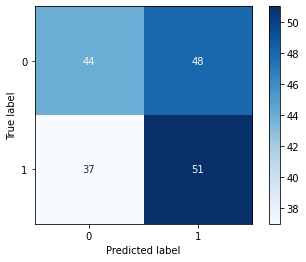

In [ ]:
print(classification_report(y_test, prediction_svm))

cm = confusion_matrix(y_test, prediction_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Random Forest

In [ ]:
# Number of trees in random forest
n_estimators = [200, 400, 2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [40, 110]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]


# Create the random grid
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(parameters)

{'n_estimators': [200, 400, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [40, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


In [ ]:
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, verbose=10)
clf.fit(X_train_2d, y_train)


sorted(clf.cv_results_.keys())

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5; 1/162] START bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/5; 1/162] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.521 total time=   0.3s
[CV 2/5; 1/162] START bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 2/5; 1/162] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.562 total time=   0.3s
[CV 3/5; 1/162] START bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 3/5; 1/162] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.618 total time=   0.3s
[CV 4/5; 1/162] START bootstrap=True, max_depth=40, max_features=auto,

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_bootstrap',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_leaf',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
prediction_rf = clf.predict(X_test_2d)

In [ ]:
clf.cv_results_["mean_test_score"]

array([0.57804002, 0.57246503, 0.57248446, 0.56132479, 0.55996503,
       0.56970668, 0.5654526 , 0.5752331 , 0.56406371, 0.57105672,
       0.56269425, 0.56825952, 0.56128594, 0.55573038, 0.57104701,
       0.55294289, 0.56825952, 0.56408314, 0.56960956, 0.57384421,
       0.57520396, 0.56267483, 0.57241647, 0.57244561, 0.57382479,
       0.57659285, 0.56824981, 0.5794289 , 0.58083722, 0.56827894,
       0.56829837, 0.56689005, 0.55574981, 0.56689005, 0.55987762,
       0.57244561, 0.56547203, 0.56826923, 0.5724359 , 0.57101787,
       0.56688034, 0.56823038, 0.56267483, 0.56268454, 0.56686092,
       0.56262626, 0.57386364, 0.57242618, 0.55432207, 0.56548174,
       0.5738345 , 0.57104701, 0.56826923, 0.57521368, 0.56691919,
       0.57107615, 0.57526224, 0.56551088, 0.5627331 , 0.5627331 ,
       0.56408314, 0.56827894, 0.56128594, 0.5543512 , 0.57101787,
       0.56824981, 0.55991647, 0.55990676, 0.56826923, 0.55571096,
       0.56687063, 0.56964841, 0.57939977, 0.57519425, 0.57245

In [ ]:
prediction_rf = clf.predict(X_test_2d)

              precision    recall  f1-score   support

           0       0.54      0.49      0.51        92
           1       0.51      0.56      0.53        88

    accuracy                           0.52       180
   macro avg       0.52      0.52      0.52       180
weighted avg       0.52      0.52      0.52       180



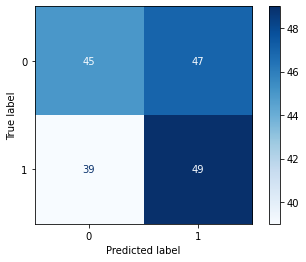

In [ ]:
print(classification_report(y_test, prediction_rf))

cm = confusion_matrix(y_test, prediction_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Neural Network

In [ ]:
X_train, y_train = resample(X_train_raw, y_train_raw, replace=True, n_samples=3000, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

torch.Size([3000, 612, 768])
torch.Size([3000])


In [ ]:
del(X_train_raw, y_train_raw, final_embeddings, labels)
gc.collect()

970

In [ ]:
np_tensor_X = X_train.numpy()
np_tensor_y = y_train.numpy()
X_train = tf.convert_to_tensor(np_tensor_X)
y_train = tf.convert_to_tensor(np_tensor_y)


np_tensor_X = X_test.numpy()
np_tensor_y = y_test.numpy()
X_test = tf.convert_to_tensor(np_tensor_X)
y_test = tf.convert_to_tensor(np_tensor_y)

In [ ]:
del(np_tensor_X, np_tensor_y)
gc.collect()

132

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3000, 612, 768)
(3000,)
(180, 612, 768)
(180,)


In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, batch_input_shape=(None, 612, 768), activation="relu"))
# model.add(tf.keras.layers.Dropout(.5, input_shape=(2,)))

model.add(tf.keras.layers.Dense(40, activation="relu"))
model.add(tf.keras.layers.Dropout(.5, input_shape=(2,)))


model.add(tf.keras.layers.Dense(30, activation="relu"))
# model.add(tf.keras.layers.Dropout(.5, input_shape=(2,)))

model.add(tf.keras.layers.Dense(20, activation="relu"))
model.add(tf.keras.layers.Dropout(.5, input_shape=(2,)))


model.add(tf.keras.layers.Dense(10, activation="relu"))
# model.add(tf.keras.layers.Dropout(.5, input_shape=(2,)))


model.add(tf.keras.layers.GlobalAveragePooling1D())


model.add(tf.keras.layers.Dense(5, activation="relu"))
#model.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))


model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
epochs = 50

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
   loss = 'binary_crossentropy', optimizer = opt, metrics = ["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 612, 50)           38450     
                                                                 
 dense_92 (Dense)            (None, 612, 40)           2040      
                                                                 
 dropout_26 (Dropout)        (None, 612, 40)           0         
                                                                 
 dense_93 (Dense)            (None, 612, 30)           1230      
                                                                 
 dense_94 (Dense)            (None, 612, 20)           620       
                                                                 
 dropout_27 (Dropout)        (None, 612, 20)           0         
                                                                 
 dense_95 (Dense)            (None, 612, 10)         

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = epochs, validation_data=(X_test, y_test), callbacks=[early_stopping_monitor])

Epoch 1/50
94/94 [==============================] - 5s 40ms/step - loss: 0.6558 - accuracy: 0.6093 - val_loss: 0.7564 - val_accuracy: 0.5500
Epoch 2/50
94/94 [==============================] - 3s 37ms/step - loss: 0.6110 - accuracy: 0.6677 - val_loss: 0.7306 - val_accuracy: 0.5722
Epoch 3/50
94/94 [==============================] - 3s 37ms/step - loss: 0.5341 - accuracy: 0.7423 - val_loss: 0.8612 - val_accuracy: 0.6222
Epoch 4/50
94/94 [==============================] - 3s 37ms/step - loss: 0.4325 - accuracy: 0.8117 - val_loss: 1.0396 - val_accuracy: 0.6056
Epoch 5/50
94/94 [==============================] - 4s 42ms/step - loss: 0.3199 - accuracy: 0.8720 - val_loss: 1.3255 - val_accuracy: 0.5889
Epoch 6/50
94/94 [==============================] - 4s 43ms/step - loss: 0.2404 - accuracy: 0.9053 - val_loss: 1.3183 - val_accuracy: 0.5500
Epoch 7/50
94/94 [==============================] - 3s 37ms/step - loss: 0.1714 - accuracy: 0.9373 - val_loss: 1.4621 - val_accuracy: 0.5778
Epoch 8/50
94

In [ ]:
# Evaluate the model on the test data using `evaluate`
#print("Evaluate on test data")
#results = model.evaluate(X_test, y_test, batch_size=32)
#print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
y_proba = model.predict(X_test)
prediction_nn = np.argmax(y_proba, axis=-1)
print("predictions shape:", prediction_nn.shape)

Generate predictions
predictions shape: (180,)


In [ ]:
prediction_nn = (model.predict(X_test) > 0.5).astype("int32")

              precision    recall  f1-score   support

           0       0.66      0.54      0.60        92
           1       0.60      0.70      0.65        88

    accuracy                           0.62       180
   macro avg       0.63      0.62      0.62       180
weighted avg       0.63      0.62      0.62       180



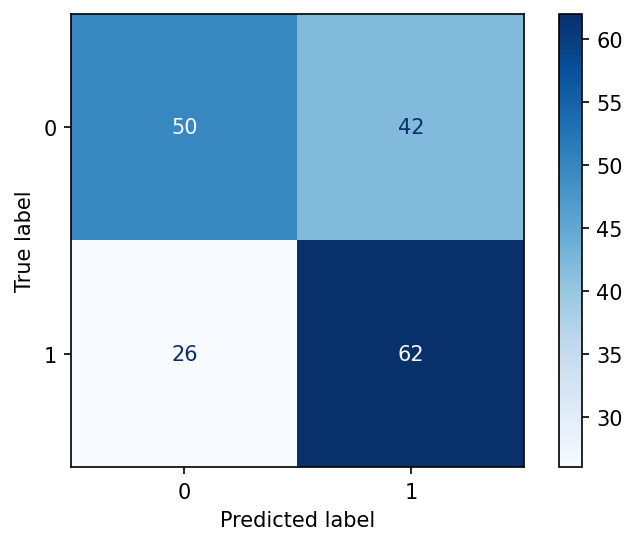

In [ ]:
print(classification_report(y_test, prediction_nn))

cm = confusion_matrix(y_test, prediction_nn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


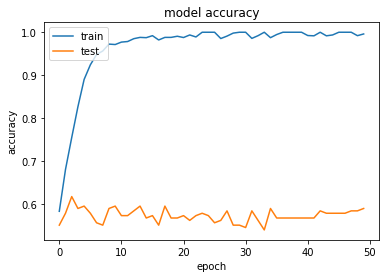

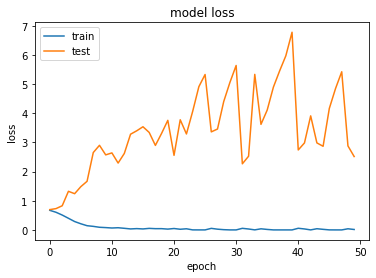

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()